In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import get_scorer_names
from sklearn.base import TransformerMixin, RegressorMixin


In [2]:
df = pd.read_csv('/kaggle/input/mai-ml-lab-1-biro/train.csv', index_col=0)
X = df.drop(columns='source_attractiveness')
Y = df['source_attractiveness']
df.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


In [3]:
class BaseDataPreprocessor(TransformerMixin):
    def __init__(self):
        self.likes_mean = dict()
        self.clicks_mean = dict()
        self.complaints_mean = dict() 
        self.dwelltime_mean = dict()
        self.buys_mean = dict()
        self.coef = dict()

    @staticmethod
    def fix_complaints_count(df):
        df.loc[df['complaints_count'] == '-', 'complaints_count'] = float('nan')
        df['complaints_count'] = df['complaints_count'].astype(float)
        return df

    @staticmethod
    def fix_average_dwelltime(df):
        df.loc[df['average_dwelltime'] < 0, 'average_dwelltime'] = float('nan')
        return df
    
    @staticmethod
    def fill_na(df, feature, mean_by_category):
        df_na = df[feature].isna()
        df[feature] = df.apply(lambda row: row[feature] if pd.notnull(row[feature]) else mean_by_category[row['category']], axis=1)
        return df
    
    def fix_clicks(self, df):
        def fix(row):
            s = row['likes'] + row['complaints_count'] + row['buys']
            if pd.isnull(row['clicks']):
                return s * self.coef[row['category']]
            else:
                return row['clicks']
            
        df['clicks'] = df.apply(fix, axis=1)
        return df

    @staticmethod
    def cast_date_of_registration(df):
        df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
        return df

    @staticmethod
    def add_age(df):
        last_date = pd.Timestamp('2024-09-30')
        df['age'] = (last_date - df['date_of_registration']) / pd.Timedelta(days=365)
        return df.drop(columns='date_of_registration')
        
    @staticmethod
    def cast_errors_and_buys(df):
        df['4xx_errors'] = df['4xx_errors'].astype(float)
        df['5xx_errors'] = df['5xx_errors'].astype(float)
        df['buys'] = df['buys'].astype(float)
        return df
    
    def fit(self, data, *args):
        data = self.fix_complaints_count(data)
        data = self.fix_average_dwelltime(data)
        self.likes_mean = dict(data[['likes', 'category']].groupby('category').mean()['likes'])
        self.clicks_mean = dict(data[['clicks', 'category']].groupby('category').mean()['clicks'])
        self.complaints_mean = dict(data[['complaints_count', 'category']].groupby('category').mean()['complaints_count'])
        self.dwelltime_mean = dict(data[['average_dwelltime', 'category']].groupby('category').mean()['average_dwelltime'])
        self.buys_mean = dict(data[['buys', 'category']].groupby('category').mean()['buys'])

        for key, value in self.clicks_mean.items():
            self.coef[key] = self.clicks_mean[key] / (self.likes_mean[key] + self.complaints_mean[key] + self.buys_mean[key])
        
        return self

    def transform(self, data, *args):
        data = self.fix_complaints_count(data)
        data = self.fix_average_dwelltime(data)
        data = self.cast_date_of_registration(data)
        data = self.cast_errors_and_buys(data)
        
        data = self.fill_na(data, 'likes', self.likes_mean)
        data = self.fill_na(data, 'average_dwelltime', self.dwelltime_mean)
        data = self.fill_na(data, 'complaints_count', self.complaints_mean)
        
        data = self.fix_clicks(data)
        data = self.add_age(data)
#         data = data.drop(columns='complaints_count')
        return data
    
    def fit_transform(self, data, *args):
        self.fit(data)
        return self.transform(data)
    

Сначала из данных убираются все пропуски и все значения приводятся к типу `float`
Для этого
- в столбце `complaints_count` все прочерки заменяются на `nan`
- в столбце `average_dwelltime` все отрицательные значения заменяются на `nan`
- столбец `date_of_registration` преобразуется в столбец `age`
- столбцы с целочисленными значениями преобразуются к типу `float`
- пропуски в столбцах `likes`, `average_dwelltime` и `complaints_count` заменяются средними значениями для каждой категории
- пропуски в столбце `clicks` заменяются суммой значений в столбцах `likes`, `buys` и `complaints_count`, умноженной на средний коэффициент отношения столбца `clicks` к перечисленным столбцам

Пропуски в столбце `clicks` не заменяются средним из-за того, что в некоторых случаях получается, что число кликов меньше суммы лайков, покупок и обращений с жалобами.

In [4]:
preprocessor = BaseDataPreprocessor()
X = preprocessor.fit_transform(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           8000 non-null   object 
 1   clicks             8000 non-null   float64
 2   likes              8000 non-null   float64
 3   buys               8000 non-null   float64
 4   4xx_errors         8000 non-null   float64
 5   5xx_errors         8000 non-null   float64
 6   complaints_count   8000 non-null   float64
 7   average_dwelltime  8000 non-null   float64
 8   age                8000 non-null   float64
dtypes: float64(8), object(1)
memory usage: 625.0+ KB


In [5]:
class FeatureGenerator(TransformerMixin):
    def __init__(self):
        self.poly = PolynomialFeatures(2, include_bias=False)
        
    @staticmethod
    def get_per_year(df, feature):
        return df[feature] / df['age'].replace(0, 1)
    
    @staticmethod
    def get_per_click(df, feature):
        return df[feature] / df['clicks'].replace(0, 1)
    
    @staticmethod
    def get_per_dwelltime(df, feature):
        return df[feature] / df['average_dwelltime'].replace(0, 1)

    def fit(self, data, *args):
        self.poly = self.poly.fit(data.drop(columns='category'))
        return self
        
    def transform(self, data, *args):
        cat = data['category']
        data = data.drop(columns='category')
        
        data_poly = self.poly.transform(data)
        cols = self.poly.get_feature_names_out(data.columns)
        
        data = pd.DataFrame(data_poly, columns=cols, index=data.index)
        
        per_year = data.apply(lambda col: self.get_per_year(data, col.name))
        per_click = data.apply(lambda col: self.get_per_click(data, col.name))
        per_dwelltime = data.apply(lambda col: self.get_per_dwelltime(data, col.name))
        
        per_year.columns = [f'{col}_per_year' for col in data.columns]
        per_click.columns = [f'{col}_per_click' for col in data.columns]
        per_dwelltime.columns = [f'{col}_per_dwelltime' for col in data.columns]

        data = pd.concat([data, per_year, per_click, per_dwelltime], axis=1)
        
        log_features = np.log1p(data)
        log_features.columns = [f'log({i})' for i in data.columns]
        
        data = pd.concat([data, log_features], axis=1)
        
        data['category'] = cat
        return data
    
    def fit_transform(self, data, *args):
        self.fit(data)
        return self.transform(data)

Дальше для данных генерируются новые признаки:
- сначала признаки преобразуются к полиномиальным со степенью <= 2
- затем каждый признак делится на возраст, количество кликов и среднее время проведенное на сайте, эти признаки добавляются к полиномиальным
- в конце к признакам добавляется логарифм, взятый от каждого признака

Так как в качестве моделей используются `ElasticNetCV`, отбор признаков можно не делать, модели сами выбирут наиболее информативные признаки.

In [6]:
feature_generator = FeatureGenerator()
X = feature_generator.fit_transform(X)
X.head()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,age,clicks^2,clicks likes,...,log(5xx_errors complaints_count_per_dwelltime),log(5xx_errors average_dwelltime_per_dwelltime),log(5xx_errors age_per_dwelltime),log(complaints_count^2_per_dwelltime),log(complaints_count average_dwelltime_per_dwelltime),log(complaints_count age_per_dwelltime),log(average_dwelltime^2_per_dwelltime),log(average_dwelltime age_per_dwelltime),log(age^2_per_dwelltime),category
6622,6488536.0,1.633087e+06,0.0,82221.0,0.0,0.0,18.450527,4.444740,4.210110e+13,1.059635e+13,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,2.967874,1.694650,0.727906,ecom
2047,874840.0,2.110000e+04,0.0,12872.0,0.0,0.0,10.721619,0.197279,7.653450e+11,1.845912e+10,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,2.461435,0.180052,0.003623,information_source
1118,571210.0,9.470700e+04,0.0,0.0,7420.0,0.0,1.922243,0.214544,3.262809e+11,5.409759e+10,...,0.00000,8.912069,6.720406,0.00000,0.000000,0.000000,1.072351,0.194368,0.023663,information_source
4992,89534.0,9.240000e+02,0.0,834.0,0.0,0.0,2.149243,0.052342,8.016337e+09,8.272942e+07,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,1.147162,0.051018,0.001274,news
9970,1043953.0,2.892880e+05,0.0,58375.0,20260.0,3948.0,3.764965,0.346676,1.089838e+12,3.020031e+11,...,16.87163,9.916453,7.531835,15.23619,8.281218,5.898607,1.561290,0.297639,0.031423,information_source


In [7]:
class Scaler(TransformerMixin):
    def __init__(self):
        self.ecom_scaler = StandardScaler()
        self.inf_scaler = StandardScaler()
        self.news_scaler = StandardScaler()
        self.porn_scaler = StandardScaler()
        self.social_scaler = StandardScaler()
    
    def split_data(self, df):
        ecom_idx, inf_idx, news_idx, porn_idx, social_idx = self.get_indicies(df)
        ecom = df[ecom_idx].drop(['category'], axis=1)
        inf = df[inf_idx].drop(['category', 'buys'], axis=1)
        news = df[news_idx].drop(['category', 'buys'], axis=1)
        porn = df[porn_idx].drop(['category', 'buys'], axis=1)
        social = df[social_idx].drop(['category', 'buys'], axis=1)
        return ecom, inf, news, porn, social

    def get_indicies(self, df):
        ecom_idx = df['category'] == 'ecom'
        inf_idx = df['category'] == 'information_source'
        news_idx = df['category'] == 'news'
        porn_idx = df['category'] == 'porn'
        social_idx = df['category'] == 'social'
        return ecom_idx, inf_idx, news_idx, porn_idx, social_idx
    
    def fit(self, data, *args):
        ecom, inf, news, porn, social = self.split_data(data)
        self.ecom_scaler = self.ecom_scaler.fit(ecom)
        self.inf_scaler = self.inf_scaler.fit(inf)
        self.news_scaler = self.news_scaler.fit(news)
        self.porn_scaler = self.porn_scaler.fit(porn)
        self.social_scaler = self.social_scaler.fit(social)
        return self

    def transform(self, data, *args):
        ecom_idx, inf_idx, news_idx, porn_idx, social_idx = self.get_indicies(data)
        data.loc[ecom_idx, self.ecom_scaler.feature_names_in_] = self.ecom_scaler.transform(data[ecom_idx].drop(columns='category'))
        data.loc[inf_idx, self.inf_scaler.feature_names_in_] = self.inf_scaler.transform(data[inf_idx].drop(columns=['category', 'buys']))
        data.loc[news_idx, self.news_scaler.feature_names_in_] = self.news_scaler.transform(data[news_idx].drop(columns=['category', 'buys']))
        data.loc[porn_idx, self.porn_scaler.feature_names_in_] = self.porn_scaler.transform(data[porn_idx].drop(columns=['category', 'buys']))
        data.loc[social_idx, self.social_scaler.feature_names_in_] = self.social_scaler.transform(data[social_idx].drop(columns=['category', 'buys']))

        return data
        
    def fit_transform(self, data, *args):
        self.fit(data)
        return self.transform(data)

Для того, чтобы все признаки вносили одинаковый вклад в веса модели, данные нормализуются с помощью `StandardScaler`. В результате мат. ожидание каждого признака становится равным 0, а дисперсия 1.

In [8]:
scaler = Scaler()
X = scaler.fit_transform(X)
X.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,age,clicks^2,clicks likes,...,log(5xx_errors^2_per_dwelltime),log(5xx_errors complaints_count_per_dwelltime),log(5xx_errors average_dwelltime_per_dwelltime),log(5xx_errors age_per_dwelltime),log(complaints_count^2_per_dwelltime),log(complaints_count average_dwelltime_per_dwelltime),log(complaints_count age_per_dwelltime),log(average_dwelltime^2_per_dwelltime),log(average_dwelltime age_per_dwelltime),log(age^2_per_dwelltime)
count,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,-4.440892e-17,-5.062617e-17,-7.216450e-18,-7.105427e-18,7.993606e-18,-1.598721e-17,-3.996803e-17,8.659740e-17,1.776357e-17,2.309264e-17,...,-3.064216e-17,-3.730349e-17,1.376677e-17,2.997602e-17,2.753353e-17,-4.352074e-17,4.796163e-17,-5.706546e-17,-3.996803e-17,-1.332268e-18
std,1.000063e+00,1.000063e+00,5.536590e-01,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,-9.123129e-01,-6.295601e-01,-5.030371e-01,-7.414125e-01,-4.152207e-01,-5.457597e-01,-1.095280e+00,-1.024580e+00,-4.295417e-01,-3.367612e-01,...,-9.476275e-01,-9.054073e-01,-9.566412e-01,-9.029034e-01,-1.964155e+00,-2.042009e+00,-1.710624e+00,-2.654925e+00,-1.651283e+00,-8.234932e-01
25%,-6.930426e-01,-5.041541e-01,0.000000e+00,-5.640063e-01,-3.847816e-01,-4.306868e-01,-7.106982e-01,-7.024296e-01,-3.917028e-01,-2.813122e-01,...,-9.374416e-01,-8.801801e-01,-9.463453e-01,-8.906994e-01,-3.303797e-01,-2.227858e-01,-6.822753e-01,-7.372369e-01,-8.039515e-01,-6.907899e-01
50%,-3.243821e-01,-3.865959e-01,0.000000e+00,-3.699720e-01,-3.588665e-01,-3.180883e-01,-2.588241e-01,-3.047017e-01,-3.313338e-01,-2.285483e-01,...,-8.841394e-01,-8.709440e-01,-9.128235e-01,-8.088672e-01,3.025583e-01,3.268594e-01,1.926233e-01,8.228207e-02,-8.998519e-02,-4.052237e-01
75%,3.345630e-01,1.344444e-02,0.000000e+00,1.296824e-01,-8.123175e-02,0.000000e+00,3.419817e-01,3.686841e-01,-6.439201e-02,-1.394426e-01,...,1.014346e+00,1.038218e+00,1.041909e+00,9.630117e-01,6.826969e-01,6.817005e-01,7.234094e-01,6.942713e-01,6.927467e-01,3.462175e-01
max,7.848674e+00,1.672873e+01,1.084695e+01,1.223428e+01,1.776584e+01,1.994510e+01,7.806817e+00,7.588947e+00,1.638110e+01,3.287899e+01,...,2.272392e+00,2.372947e+00,1.917879e+00,3.027703e+00,2.362067e+00,1.802354e+00,3.277846e+00,3.004824e+00,3.430460e+00,8.271444e+00


Так как распределение таргета для `ecom` сильно отличается от распределений таргета для других категорий, то для его предсказания используется оттдельная модель

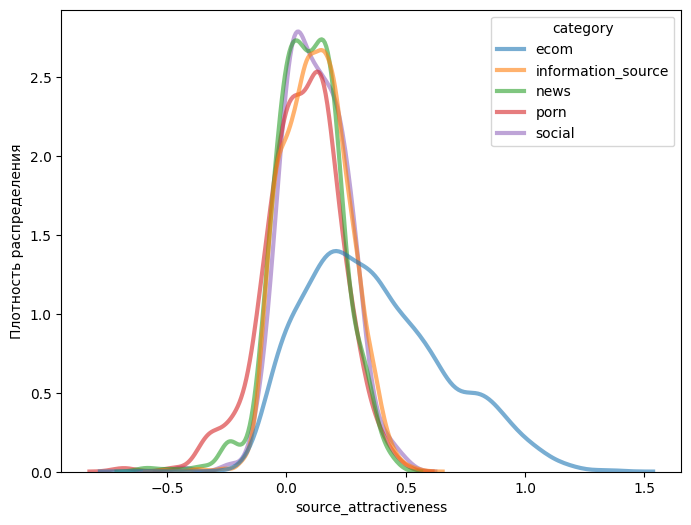

In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)
x = df['source_attractiveness']
y = df['category']

fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(x=x, hue=y, ax=ax, common_norm=False, lw=3, alpha=0.6)

ax.set_xlabel('source_attractiveness')
ax.set_ylabel('Плотность распределения')

plt.show()

Из матрицы корреляций видно, что признак `likes` имеет небольшую корреляцию с таргетом и с категорией `information_source`, при этом с другими категориями у `likes` корреляция отрицательная. Так как категория `information_source` самая многочисленная, то для увеличения влияния лайков в этой категории, для нее тоже используется оттдельная модель. Для остальных категорий эффективность использования отдельных моделей подтвердилась экспериментально. Несмотря на то, что данных для каждой модели получается немного, так как модели линейные, метрика все равно улучшается. 

In [10]:
df.groupby('category').count()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
category,,,,,,,,,
ecom,2360,2336,2452,2452,2452,2284,2452,2452,2452
information_source,3815,3759,3934,3934,3934,3722,3934,3934,3934
news,779,774,816,816,816,767,816,816,816
porn,370,362,383,383,383,360,383,383,383
social,403,393,415,415,415,394,415,415,415


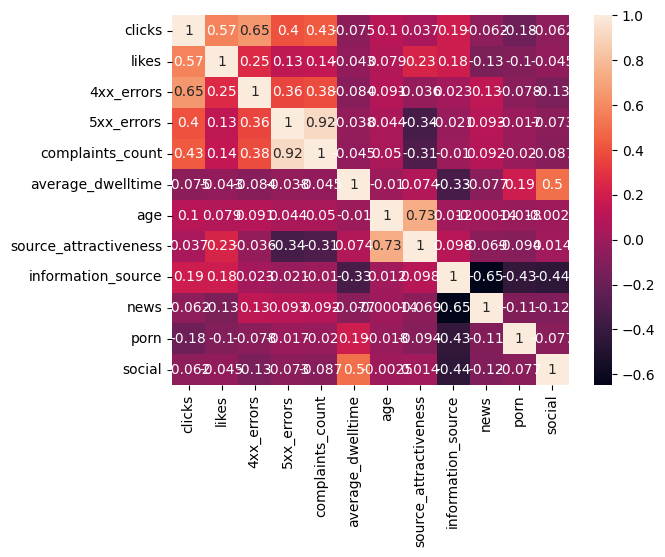

In [11]:
corr_df = preprocessor.transform(df.drop(columns='source_attractiveness'))
corr_df['source_attractiveness'] = Y

encoder = OneHotEncoder(sparse_output=False)
one_hot_category_matrix = encoder.fit_transform(corr_df[['category']])
categorial_features = encoder.categories_[0]

one_hot_df = pd.DataFrame(one_hot_category_matrix, columns=categorial_features, index=corr_df.index, dtype=int)
corr_df = corr_df.join(one_hot_df)

corr = corr_df[corr_df['category'] != 'ecom'].drop(columns=['category', 'buys', 'ecom']).corr()
sns.heatmap(corr, annot=True)
plt.show()

In [12]:
class DomainRegression(RegressorMixin):
    def __init__(self, *args, **kwargs):
        self.ecom_model = ElasticNetCV(*args, **kwargs)
        self.inf_model = ElasticNetCV(*args, **kwargs)
        self.news_model = ElasticNetCV(*args, **kwargs)
        self.porn_model = ElasticNetCV(*args, **kwargs)
        self.social_model = ElasticNetCV(*args, **kwargs)

    def split_data(self, df):
        ecom_idx, inf_idx, news_idx, porn_idx, social_idx = self.get_indicies(df)
        ecom = df[ecom_idx].drop(['category'], axis=1)
        inf = df[inf_idx].drop(['category'], axis=1)
        news = df[news_idx].drop(['category'], axis=1)
        porn = df[porn_idx].drop(['category'], axis=1)
        social = df[social_idx].drop(['category'], axis=1)
        return ecom, inf, news, porn, social

    def get_indicies(self, df):
        ecom_idx = df['category'] == 'ecom'
        inf_idx = df['category'] == 'information_source'
        news_idx = df['category'] == 'news'
        porn_idx = df['category'] == 'porn'
        social_idx = df['category'] == 'social'
        return ecom_idx, inf_idx, news_idx, porn_idx, social_idx
    
    def fit(self, X, Y, *args):
        df_Y = pd.DataFrame(Y)
        df_Y['category'] = X['category']
        ecom_X, inf_X, news_X, porn_X, social_X = self.split_data(X)
        ecom_Y, inf_Y, news_Y, porn_Y, social_Y = self.split_data(df_Y)

        self.ecom_model = self.ecom_model.fit(ecom_X, ecom_Y['source_attractiveness'])
        self.inf_model = self.inf_model.fit(inf_X.drop(['buys'], axis=1), inf_Y['source_attractiveness'])
        self.news_model = self.news_model.fit(news_X.drop(['buys'], axis=1), news_Y['source_attractiveness'])
        self.porn_model = self.porn_model.fit(porn_X.drop(['buys'], axis=1), porn_Y['source_attractiveness'])
        self.social_model = self.social_model.fit(social_X.drop(['buys'], axis=1), social_Y['source_attractiveness'])
        
        return self

    def predict(self, X, *args):
        ecom_idx, inf_idx, news_idx, porn_idx, social_idx = self.get_indicies(X)

        pred = np.zeros((X.shape[0]), dtype=float)        

        pred[ecom_idx] = self.ecom_model.predict(X.loc[ecom_idx, self.ecom_model.feature_names_in_])
        pred[inf_idx] = self.inf_model.predict(X.loc[inf_idx, self.inf_model.feature_names_in_])
        pred[news_idx] = self.news_model.predict(X.loc[news_idx, self.news_model.feature_names_in_])
        pred[porn_idx] = self.porn_model.predict(X.loc[porn_idx, self.porn_model.feature_names_in_])
        pred[social_idx] = self.social_model.predict(X.loc[social_idx, self.social_model.feature_names_in_])

        return pred

    def get_params(self, deep=True):
        return self.ecom_model.get_params(deep)

    def set_params(self, **params):
        self.ecom_model.set_params(**params)
        self.inf_model.set_params(**params)
        self.news_model.set_params(**params)
        self.porn_model.set_params(**params)
        self.social_model.set_params(**params)
        return self

    def __repr__(self):
        return f"DomainRegression({self.model.get_params()})"

In [13]:
df = pd.read_csv('/kaggle/input/mai-ml-lab-1-biro/train.csv', index_col=0)
X = df.drop(columns='source_attractiveness')
Y = df['source_attractiveness']
df.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


Из списков параметров модели сами подберут оптимальные значения

In [14]:
alphas = np.logspace(-1, 5, 100)
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]

Для удобства использования, все объединено в pipeline

In [15]:
pipe = Pipeline([
    ('preprocessor', BaseDataPreprocessor()), 
    ('feature_generator', FeatureGenerator()), 
    ('scaler', Scaler()), 
    ('model', DomainRegression(l1_ratio=l1_ratio, alphas=alphas))
])

In [16]:
cv = KFold(n_splits=5, shuffle=True)

In [17]:
scores = cross_validate(
    estimator=pipe,
    X=X,
    y=Y,
    cv=cv,
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'),
    n_jobs=-1
)
scores

{'fit_time': array([15.55703497, 14.77675176, 16.29710007, 15.68383837,  8.68883252]),
 'score_time': array([0.84825373, 0.91978121, 0.72122192, 0.91807199, 0.53639293]),
 'test_r2': array([0.94543905, 0.94677796, 0.93450661, 0.93404822, 0.93945817]),
 'test_neg_mean_squared_error': array([-0.00271632, -0.00290463, -0.0034331 , -0.00340808, -0.00308979]),
 'test_neg_mean_absolute_percentage_error': array([-0.98330605, -1.23255913, -1.06585596, -0.99375469, -0.96877953])}

In [18]:
-scores['test_neg_mean_squared_error'].mean()

0.0031103837214495394

In [19]:
scores['test_r2'].mean()

0.9400460017067903

In [20]:
-scores['test_neg_mean_absolute_percentage_error'].mean()

1.0488510726532976

In [21]:
pipe = pipe.fit(X, Y)

In [22]:
test = pd.read_csv('/kaggle/input/mai-ml-lab-1-biro/test.csv', index_col=0)

In [23]:
pred = pipe.predict(test)

In [24]:
pred

array([0.49416959, 0.03665326, 0.59805816, ..., 0.02202503, 0.19726009,
       0.05892785])

In [25]:
df = pd.read_csv('/kaggle/input/mai-ml-lab-1-biro/test.csv', index_col=0)

data = {
    "source_attractiveness": pred
}
submit = pd.DataFrame(data)
submit.to_csv('/kaggle/working/submission.csv', index_label="ID")